### pain questionnaire based classification dev

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [3]:
from compare_painquestion import objective, make_data_painquestion
from compare_hyperparams import load_feats, feature_importance, load_modZ_multi, load_cv, top_mods, print_clf_table
from compare_bfl_qsidp import load_qscode, match_question, proc_qsidp

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


#### load bigflica data

In [4]:
curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
cv_dir = os.path.join(curr_dir, 'cv_results', 'painquestion')

In [5]:
df = load_cv(cv_dir).reset_index()

   max_depth  n_estimators  max_features  min_samples_split  min_samples_leaf  \
0          2           100      0.794981                  3                 8   
1          2            50      0.991891                 11                14   
2          3           250      0.665036                  6                 2   
3          2           200      0.954555                  2                 2   
4          3            50      0.805721                  8                13   

   max_samples  balanced_accuracy   roc_auc  bestIC               qsidp  
0     0.606544           0.506949  0.515178     500                None  
1     0.859238           0.520859  0.527663     500          ['t1vols']  
2     0.947460           0.515481  0.517981     500  ['subcorticalvol']  
3     0.645227           0.519601  0.519727     500            ['fast']  
4     0.801930           0.506165  0.514010     500          ['t2star']  


In [6]:
df.shape

(400, 11)

In [7]:
df.iloc[df['balanced_accuracy'].argmax()]

index                                                  13
max_depth                                               3
n_estimators                                           50
max_features                                     0.152889
min_samples_split                                       7
min_samples_leaf                                       14
max_samples                                      0.706131
balanced_accuracy                                0.573985
roc_auc                                          0.600917
bestIC                                                 30
qsidp                ['cognitive', 'lifestyle', 'mental']
Name: 77, dtype: object

In [8]:
print_clf_table(df, n=3)

\begin{tabular}{lrrr}
\toprule
                     Feature items &  Imaging components &  Balanced accuracy &  ROC AUC \\
\midrule
'cognitive', 'lifestyle', 'mental' &                  30 &              0.574 &    0.601 \\
                          'mental' &                 100 &              0.573 &    0.591 \\
           'demographic', 'mental' &                  30 &              0.573 &    0.596 \\
\bottomrule
\end{tabular}



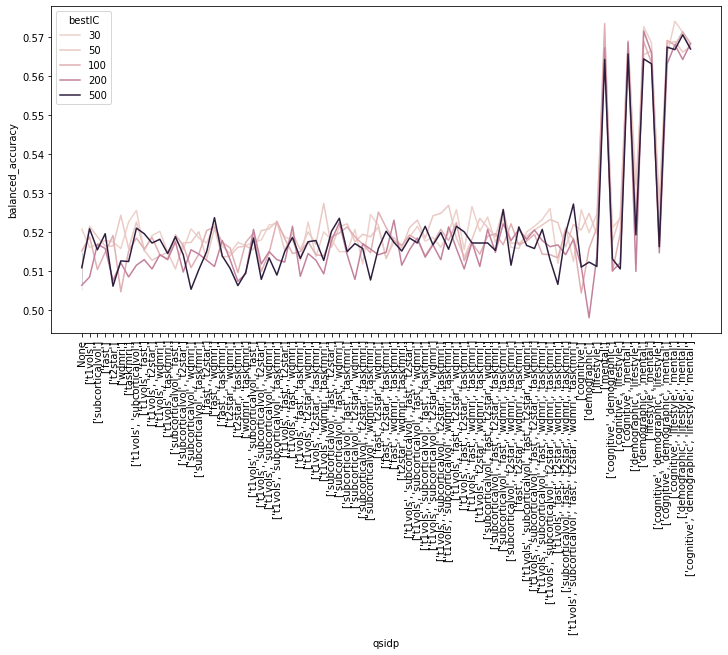

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.lineplot(data=df, x='qsidp', y='balanced_accuracy', hue='bestIC', ax=ax)
_ = plt.xticks(rotation=90)

#### check importance

In [10]:
bestIC = 30
qs_ls = ['cognitive', 'lifestyle', 'mental']
idp_ls = None

In [11]:
bp = df.iloc[df['balanced_accuracy'].argmax()].to_dict()

In [12]:
for i in ['balanced_accuracy', 'roc_auc', 'bestIC', 'qsidp','index']:
    del bp[i]

In [13]:
bp

{'max_depth': 3,
 'n_estimators': 50,
 'max_features': 0.1528890712229466,
 'min_samples_split': 7,
 'min_samples_leaf': 14,
 'max_samples': 0.7061310128493092}

In [28]:
# load bfl
df_bfl_qsidp = make_data_painquestion(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(8776, 269)
df_bfl_qsidp shape=(8776, 301)
(8776, 298)


In [90]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=0.1528890712229466,
                       max_samples=0.7061310128493092, min_samples_leaf=14,
                       min_samples_split=7, n_estimators=50, random_state=0)

In [91]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

4744
0.6091905564924114
0.6091905564924115


In [92]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

1582
0.5790139064475348
0.5790139064475348


In [93]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.612345588247046

In [94]:
output_ls = ['label', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [95]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [96]:
feat_sorted = feat_importances.sort_values(ascending=False)

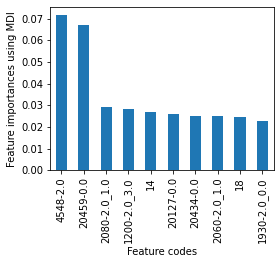

In [97]:
fig, ax = plt.subplots(figsize=(4,3))
feat_sorted.iloc[:10].plot.bar(ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
ax.set_ylabel('Feature importances using MDI')
ax.set_xlabel('Feature codes')
plt.savefig('figs/painquestion_featureimportance.png', bbox_inches='tight', dpi=200)

In [98]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Health satisfaction'], dtype=object),
 array(['General happiness with own health'], dtype=object),
 array(['Frequency of tiredness / lethargy in last 2 weeks'], dtype=object),
 array(['Sleeplessness / insomnia'], dtype=object),
 array(['Neuroticism score'], dtype=object),
 array(['Age at last episode of depression'], dtype=object),
 array(['Frequency of unenthusiasm / disinterest in last 2 weeks'],
       dtype=object),
 array(['Miserableness'], dtype=object)]

#### visualising top feature

In [99]:
data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_painquestion_500/Result_IC30/'

top feature: 14


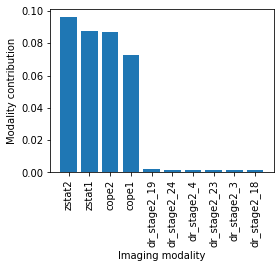

In [100]:
top_feat, mod_ls = top_mods(data_dir, top_feat=14, mod_num=10)
plt.savefig('figs/painquestion_contribution.png', bbox_inches='tight', dpi=200)

(228453, 30)
(228453, 30)
(228453, 30)
(228453, 30)


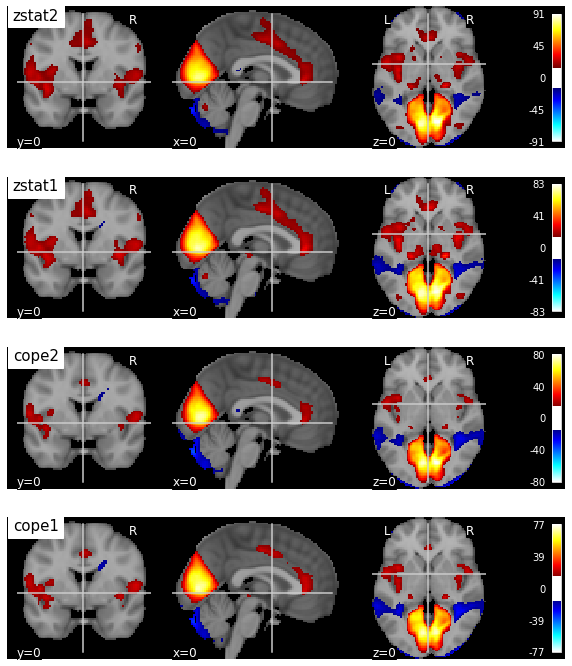

In [102]:
load_modZ_multi(data_dir, modality_ls=mod_ls, feature_num=top_feat, 
                plot_threshold=15, save_name='painquestion_bfl.png')